## Quick check of whether sampling request up to capacity works...

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [112]:
path = "../raw_output/Samples/requests_sample_Facility_3_size_limit_100.csv"

In [113]:
requests = pd.read_csv(path)

In [114]:
len(requests)

3171

In [115]:
requests.head(3)

,Unnamed: 0,index,EntryDateTime,ExitDateTime,HoursStay,MinutesStay,RevenueAmount,SiteID,Year,EntryDate,...,EV_yn,request_charge_yn,home_charging_yn,BatterySize,final_kWhRequested_Coll_Filter,daily_travel_km,final_kWhRequested_travel_demand,final_kWhRequested_updated,StayDuration,StayDurationMinutes
0,116,0,2019-01-01 00:32:40,2019-01-01 00:34:59,0.033333,2,0.0,Facility_3,2019,2019-01-01,...,1,0,1,30.0,0.0,13.421896,0.0,0.0,0 days 00:02:19.000000000,2.316667
1,54,2,2019-01-01 00:35:12,2019-01-01 00:37:26,0.033333,2,0.0,Facility_3,2019,2019-01-01,...,1,0,1,23.0,0.0,359.605414,0.0,0.0,0 days 00:02:14.000000000,2.233333
2,239,3,2019-01-01 00:35:55,2019-01-01 00:37:42,0.033333,2,0.0,Facility_3,2019,2019-01-01,...,1,0,1,30.0,0.0,42.798788,0.0,0.0,0 days 00:01:47.000000000,1.783333


In [116]:
# HELPERS
def round_down_to_base (num,base):
    return num - (num%base)


def minutes_from_midnight(dt):
    mfm = dt.hour * 60 + dt.minute
    return mfm

In [117]:
def get_occupancy(requests_df,agg_level=5):
    """
    calculates occupancy from requests
    :param requests_df:
    :param agg_level:
    :return:
    """
    
    dict_rename={"EntryDateTime":"arrival_time","ExitDateTime":"departure_time","EV_yn":"ev_yn",
                 "SiteID":"facility","ClusterName":"user_type","index":"vehicle_id"}
    
    requests_df.rename(columns=dict_rename,inplace=True)

    # settings
    agg_level = agg_level #minutes

    # set entry/exit time to target res
    requests_df["arrival_time"] = pd.to_datetime(requests_df["arrival_time"])
    requests_df["departure_time"] = pd.to_datetime(requests_df["departure_time"])
    requests_df["arrival_time"] = requests_df["arrival_time"].apply(lambda x: x.replace(second=0, minute=round_down_to_base(x.minute,agg_level)))
    requests_df["departure_time"] = requests_df["departure_time"].apply(lambda x: x.replace(second=0, minute=round_down_to_base(x.minute,agg_level)))#.apply(lambda x: x.replace(second=0, microsecond=0))

    # count entries and exits per time period in separate df
    entry_counts = requests_df.groupby(["facility","ev_yn","user_type","arrival_time"],as_index=False).agg({"vehicle_id":"count"})
    entry_counts.columns=["facility","ev_yn","user_type","time","entry_counts"]
    entry_counts["key"] = entry_counts.apply(lambda x: "{}_{}_{}_{}".format(x.facility,x.ev_yn,x.user_type,x.time),axis=1)

    exit_counts = requests_df.groupby(["facility","ev_yn","user_type","departure_time"],as_index=False).agg({"vehicle_id":"count"})
    exit_counts.columns=["facility","ev_yn","user_type","time","exit_counts"]
    exit_counts["key"] = exit_counts.apply(lambda x: "{}_{}_{}_{}".format(x.facility,x.ev_yn,x.user_type,x.time),axis=1)

    # compute target index
    target_index = pd.DataFrame()
    #requests_df["arrival_time"] = requests_df["arrival_time"].apply(lambda x: x.replace(second=0))
    #requests_df["departure_time"] = requests_df["arrival_time"].apply(lambda x: x.replace(second=0))
    for facility in requests_df["facility"].unique():
        for ev in requests_df["ev_yn"].unique():
            for cluster in requests_df["user_type"].unique():
                out=pd.DataFrame()
                out["time"]= pd.date_range(start=requests_df["arrival_time"].min(), end=requests_df["departure_time"].max(),freq="{}S".format(agg_level*60))
                out["facility"] = facility
                out["ev_yn"] = ev
                out["user_type"] = cluster
                out["key"] = out.apply(lambda x: "{}_{}_{}_{}".format(x.facility,x.ev_yn,x.user_type,x.time),axis=1)

                #print(facility,cluster)
                target_index = target_index.append(out)

    # merge into occupancy df
    occupancy_df = target_index.merge(entry_counts[["key","entry_counts"]],on="key",how="left")
    occupancy_df = occupancy_df.merge(exit_counts[["key","exit_counts"]],on="key",how="left")
    occupancy_df.fillna(0, inplace=True) # fill periods with no entries/exits
    occupancy_df["net_occupancy_change"] = occupancy_df["entry_counts"] - occupancy_df["exit_counts"] # get net occupancy change

    # compute occupancy per facility, user type, ev
    occupancy_final = pd.DataFrame()

    for facility in occupancy_df["facility"].unique():
        for ev in occupancy_df["ev_yn"].unique():
            for cluster in occupancy_df["user_type"].unique():
                out_df = occupancy_df[(occupancy_df["facility"] == facility) & (occupancy_df["ev_yn"] == ev) &
                                      (occupancy_df["user_type"] == cluster)]

                out_df.sort_values(by="time", inplace=True, ascending=True)
                out_df["total_occupancy"] = out_df["net_occupancy_change"].cumsum()

                occupancy_final = occupancy_final.append(out_df)

    #times
    occupancy_final["date"] = occupancy_final["time"].apply(lambda x: x.date())
    occupancy_final["hour"] = occupancy_final["time"].apply(lambda x: x.hour)
    occupancy_final["minutes_from_midnight"] = occupancy_final["time"].apply(lambda x: minutes_from_midnight(x))

    return occupancy_final


In [130]:
occ = get_occupancy(out,agg_level=5)

/Users/schroerk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/schroerk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/schroerk/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/schroerk/miniconda3/lib/python3.7/site-packages/ipy

In [131]:
occ_agg = occ.groupby(["time","facility"]).agg({"entry_counts":"sum","exit_counts":"sum",
                                      "net_occupancy_change":"sum","total_occupancy":"sum"})

In [132]:
occ_agg.reset_index(inplace=True)

In [133]:
occ_agg["total_occupancy"].max()

293.0

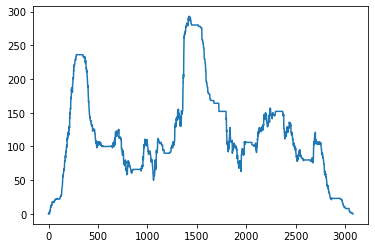

In [134]:
plt.plot(occ_agg["total_occupancy"])

In [127]:
def sample_daily_requests_up_to_capacity(df, max_occupancy, temp_res=5, margin=0.005, replace=False, seed=42,
                                         verbose=False):
    """
    Function samples sufficient parking events up to the desired capacity for each facility and day contained in df
    :param df: base df of parking events
    :param facility_names: list of facilities (can only be 1)
    :param max_occupancy: desired max. occupancy
    :param temp_res: temporal resolution at which occupancy is computed (in minutes)
    :param margin: margin (in %) on deviation from max occupancy
    :param replace: sample with replacement?
    :param seed: fix see or not for replication purposes
    :return:
    """
    if margin > 1 or margin < 0:
        raise ValueError("Margin (%) must be in interval [0,1]!!!")

    # set entry/exit time to target res
    df["arrival_time"] = pd.to_datetime(df["arrival_time"])
    df["departure_time"] = pd.to_datetime(df["departure_time"])
    temp_res = temp_res  # minutes!
    df["EntryDateTime{}min".format(temp_res)] = df["arrival_time"].apply(lambda x: x.replace(second=0, minute=round_down_to_base(x.minute, temp_res)))
    df["ExitDateTime{}min".format(temp_res)] = df["departure_time"].apply(lambda x: x.replace(second=0, minute=round_down_to_base(x.minute, temp_res)))

    # per each facility and day sample events up to target occupation and collect

    final_df = pd.DataFrame()
    
    for facility_name in df["facility"].unique():

        out_df = pd.DataFrame()
        carry_over_events_df = pd.DataFrame() #initialize

        for day in df["EntryDate"].unique():

            # select facility and day
            day_df = df[(df["facility"] == facility_name) & (df["EntryDate"] == day)]

            # sample events up to max_occupancy
            event_count = round(max_occupancy)  # initialize to 2.5 the max occupancy (seems like a good value)

            while True:
                # sample n=event_count events
                #print(event_count)
                day_df_sampled = day_df.sample(n=event_count, replace=replace, random_state=seed)
                day_df_sampled = day_df_sampled.append(carry_over_events_df)

                # simulate occupancy over day and find max
                ## count entries and exits per time period in separate df
                entry_counts = day_df_sampled[
                    ["EntryDateTime{}min".format(temp_res), "ExitDateTime{}min".format(temp_res)]] \
                    .groupby(["EntryDateTime{}min".format(temp_res)]).count()
                entry_counts.reset_index(inplace=True)
                entry_counts.columns = ["DateTime{}min".format(temp_res), "EntryCounts"]

                exit_counts = day_df_sampled[
                    ["EntryDateTime{}min".format(temp_res), "ExitDateTime{}min".format(temp_res)]] \
                    .groupby(["ExitDateTime{}min".format(temp_res)]).count()
                exit_counts.reset_index(inplace=True)
                exit_counts.columns = ["DateTime{}min".format(temp_res), "ExitCounts"]

                ## compute target index
                target_index = pd.DataFrame()
                target_index["DateTime{}min".format(temp_res)] = pd.date_range(
                    start=day_df_sampled["EntryDateTime{}min".format(temp_res)].min(),
                    end=day_df_sampled["EntryDateTime{}min".format(temp_res)].max(),
                    freq="{}S".format(temp_res * 60))
                ## merge entry and exit counts and compute total occupancy per interval
                occupancy = target_index.merge(entry_counts, on="DateTime{}min".format(temp_res), how="left")
                occupancy = occupancy.merge(exit_counts, on="DateTime{}min".format(temp_res), how="left")
                occupancy.fillna(0, inplace=True)
                occupancy["NetOccupancyChange"] = occupancy["EntryCounts"] - occupancy["ExitCounts"]
                occupancy["TotalOccupancy"] = occupancy["NetOccupancyChange"].cumsum()  # gets cumulative sum of occupancy change!

                max_daily_occ = max(occupancy["TotalOccupancy"])
                if verbose:
                    print(max_daily_occ)
                # update event count if not max_occupancy not within margin, else break
                if max_daily_occ > round(max_occupancy + (margin * max_occupancy)):
                    if event_count > 0: #ensure we do not get negative event count!
                        event_count += (-1)  # reduce event counts if above max_occupancy + margin
                    else:
                        print("Warning! No samples taken for this day!")
                        break
                    if verbose:
                        print("occupancy too large")
                elif max_daily_occ < round(max_occupancy - (margin * max_occupancy)):
                    event_count += 1  # increase event counts if below max_occupancy
                    if verbose:
                        print("occupancy too small")
                elif np.absolute(max_daily_occ - max_occupancy) <= round(margin * max_occupancy):
                    print("Facility {}; Day {}: occupancy within margin at {} parking events".format(facility_name, day,
                                                                                                     event_count))
                    break  # break loop if within margin


            # append to out_df
            out_df = out_df.append(day_df_sampled)
            carry_over_events_df = out_df[out_df["ExitDate"]>day]

        # append facility df to final df
        final_df = final_df.append(out_df)

    return final_df

In [128]:
requests.columns

Index(['Unnamed: 0', 'vehicle_id', 'arrival_time', 'departure_time',
       'HoursStay', 'MinutesStay', 'RevenueAmount', 'facility', 'Year',
       'EntryDate', 'DayType', 'ExitDate', 'EntryHour', 'ExitHour',
       'EntryDayOfWeek', 'EntryWeekday_yn', 'EntryHoliday_yn',
       'userInputs_kWhPerkm', 'userInputs_kWhRequested',
       'userInputs_kmRequested', 'MaxFeasible_kwhRequested',
       'final_kWhRequested', 'ClusterNum', 'user_type', 'FacilityType',
       'ev_yn', 'request_charge_yn', 'home_charging_yn', 'BatterySize',
       'final_kWhRequested_Coll_Filter', 'daily_travel_km',
       'final_kWhRequested_travel_demand', 'final_kWhRequested_updated',
       'StayDuration', 'StayDurationMinutes', 'EntryDateTime5min',
       'ExitDateTime5min'],
      dtype='object')

In [129]:
out = sample_daily_requests_up_to_capacity(df=requests, max_occupancy=100, temp_res=5, margin=0.005,replace=False, seed=42,verbose=True)

32.0
occupancy too small
32.0
occupancy too small
32.0
occupancy too small
33.0
occupancy too small
34.0
occupancy too small
34.0
occupancy too small
34.0
occupancy too small
34.0
occupancy too small
34.0
occupancy too small
35.0
occupancy too small
35.0
occupancy too small
36.0
occupancy too small
37.0
occupancy too small
37.0
occupancy too small
38.0
occupancy too small
38.0
occupancy too small
38.0
occupancy too small
38.0
occupancy too small
38.0
occupancy too small
39.0
occupancy too small
39.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
40.0
occupancy too small
41.0
occupancy too small
41.0
occupancy too small
41.0
occupancy too small
42.0
occupancy too small
42.0
occupancy too small
43.0
occupancy too small
43.0
occupancy too small
44.0
occupancy too small
44.0
occupancy too small
